# 十分钟强化学习第十讲：策略梯度方法

## Policy gradient methods理解

- value-base 方法是先根据Q值评估策略，再进行策略调整
- Policy-base 方法直接调整Policy Function，使其在环境中的表现最好(E(V0))
- 可以直接处理高维或连续的action space

## policy gradient的定义：

policy_gradient = -(returns * logpas).mean()

- returns是一串行为轨迹中某个action后的收益之和
- log_prob_action是某个action的概率值取log
- 如果一个action之后取得正的return，公式取正值，torch会让预测概率向1的方向修正
- 如果一个action之后取得负的return，公式取负值，torch会让预测概率向0的方向修正
- 这样就“强化”了正确的action，“弱化”了错误的action

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

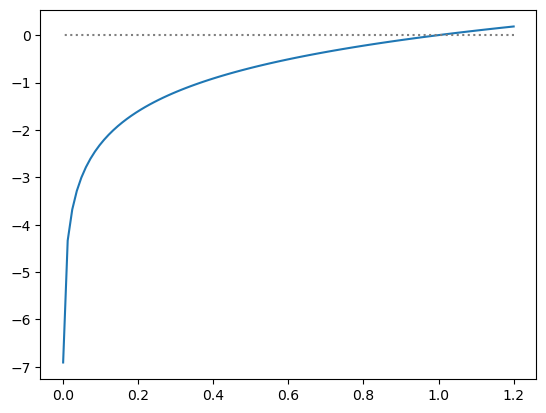

In [3]:
x = np.linspace(0.001, 1.2, 100)
y = np.log(x)
plt.plot(x,y)
plt.hlines(0.001, 1.2,0,linestyles='dotted',color = 'grey')

## REINFORCE代码实现

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import numpy as np
import random

In [14]:
class Linear_PNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, state, explore):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)

        x = F.relu(self.linear1(state))
        x = self.linear2(x)
        probs = F.softmax(x, dim=0)
        action = self.get_action(probs, explore=explore)
        log_prob_action = torch.log(probs)[action]
        return action, log_prob_action
    
    
    def get_action(self, probs, explore):
        probs = probs.detach().numpy()
        if explore:
            return np.random.choice(len(probs), p=probs)
        else:
            return probs.argmax()
        

In [15]:
class REINFORCE:
    def __init__(self, state_space, action_space):
        self.policy_model = Linear_PNet(state_space,16,action_space)
        self.optimizer = optim.Adam(self.policy_model.parameters(), lr=0.0001)
        self.gamma = 0.99
        self.state_space = state_space

    def reset(self):
        self.logpas = []
        self.rewards = []
        self.step = 0

    def optimize_model(self):
        T = len(self.rewards)
        discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)
        returns = np.array([np.sum(discounts[:T-t] * self.rewards[t:]) for t in range(T)])

        discounts = torch.FloatTensor(discounts)
        returns = torch.FloatTensor(returns)
        self.logpas_tensor = torch.stack(self.logpas)

        # Loss for pytorch
        policy_gradient = -(returns * self.logpas_tensor).mean()

        self.optimizer.zero_grad()
        policy_gradient.backward()
        self.optimizer.step()

    def interaction_step(self, state, env, explore):
        action, logpa = self.policy_model(state,explore)
        new_state, reward, is_terminal, _, _ = env.step(action)
        self.step += 1
        new_state = self.one_hot(new_state,self.state_space)
        new_state = torch.tensor(new_state, dtype=torch.float32)
        self.logpas.append(logpa)
        if self.step > 100 and not is_terminal:
            is_terminal = True
        if is_terminal and reward == 0:
            self.rewards.append(-1)
        else:
            self.rewards.append(reward)

        return new_state, reward, is_terminal
    
    @staticmethod
    def one_hot(x,size):
        result = np.zeros(size)
        result[x] = 1
        return result 

In [16]:
def train(env,max_episodes=80000, max_explore = 5000):
    agent = REINFORCE(env.observation_space.n,env.action_space.n)
    n_game = 0
    total_step = 0
    results = []
    for _ in range(max_episodes):
        agent.reset()
        state, _ = env.reset()
        is_terminal = False
        state = agent.one_hot(state,env.observation_space.n)
        while not is_terminal:
            epsilon = max_explore - n_game
            isExplore = random.randint(0, max_explore) < epsilon
            state, reward, is_terminal = agent.interaction_step(state, env, isExplore)
            total_step += 1
            if is_terminal:
                results.append(reward>0)
        
        agent.optimize_model()
        n_game += 1

        if (n_game>0) and (n_game % 1000 ==0):         
            print("Running episode  {}, step {} Reaches goal {:.2f}%. ".format(
                n_game, total_step,np.sum(results[-100:]))) 


In [17]:
env = gym.make('FrozenLake-v1')
train(env, 20000,10000)

Running episode  1000, step 8022 Reaches goal 1.00%. 
Running episode  2000, step 16478 Reaches goal 1.00%. 
Running episode  3000, step 25877 Reaches goal 1.00%. 
Running episode  4000, step 35134 Reaches goal 1.00%. 
Running episode  5000, step 44265 Reaches goal 4.00%. 
Running episode  6000, step 53895 Reaches goal 7.00%. 
Running episode  7000, step 63409 Reaches goal 3.00%. 
Running episode  8000, step 73302 Reaches goal 7.00%. 
Running episode  9000, step 83858 Reaches goal 10.00%. 
Running episode  10000, step 95291 Reaches goal 8.00%. 
Running episode  11000, step 126497 Reaches goal 60.00%. 
Running episode  12000, step 162682 Reaches goal 60.00%. 
Running episode  13000, step 197920 Reaches goal 62.00%. 
Running episode  14000, step 234169 Reaches goal 68.00%. 
Running episode  15000, step 269273 Reaches goal 54.00%. 
Running episode  16000, step 306780 Reaches goal 62.00%. 
Running episode  17000, step 347555 Reaches goal 75.00%. 
Running episode  18000, step 388000 Reaches